In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### 데이터프레임 확인

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
train.describe()

### 변수 확인

In [ ]:
len(train.columns), train.columns

In [ ]:
train.info()

In [ ]:
numeric_feats = [f for f in train.columns if train.dtypes[f] != 'object']

#ID & SalePrice 제외 36개
numeric_feats.remove('SalePrice')
numeric_feats.remove('Id')

len(numeric_feats), numeric_feats

In [ ]:
categorical_feats = [f for f in train.columns if train.dtypes[f] == 'object']
len(categorical_feats), categorical_feats

- Total number of attributes equals 81, of which 36 is quantitative, 43 categorical + Id and SalePrice.

### 타겟 확인

In [ ]:
train['SalePrice'].describe()

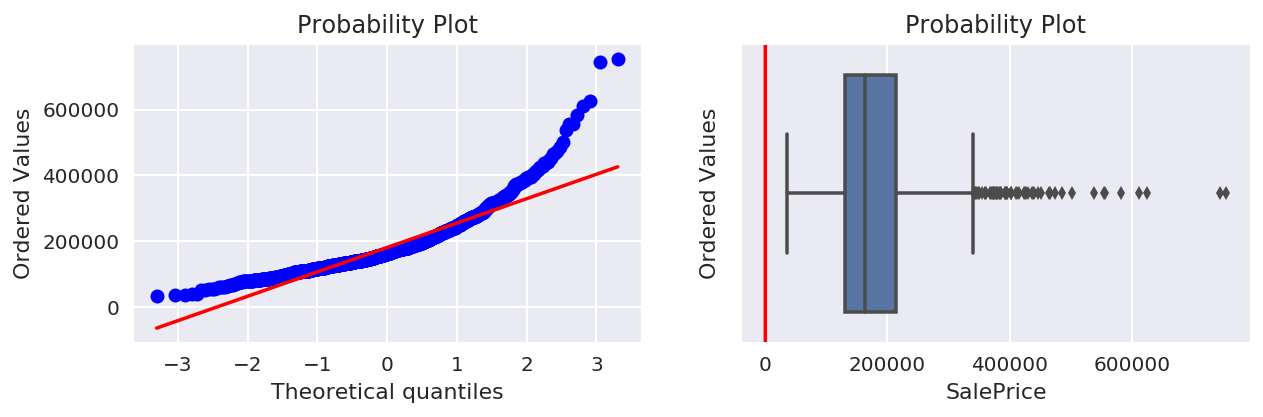

In [5]:

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train['SalePrice'])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# #Now plot the distribution
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.ylabel('Frequency')
# plt.title('SalePrice distribution')

# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(train['SalePrice'], plot=plt)
# plt.show()

#sns.distplot(train['SalePrice'] , fit=norm);




plt.figure(figsize=(10,6))

plt.subplot(221)
res = stats.probplot(train['SalePrice'], plot=plt)

plt.subplot(222)
res = stats.probplot(train['SalePrice'], plot=plt)




# plt.subplot(221)
# res = stats.probplot(train['SalePrice'], plot=plt)

### train + test

In [ ]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop('SalePrice', axis=1, inplace=True)
all_data.drop('Id', axis=1, inplace=True)

In [ ]:
all_data.shape

In [ ]:
all_data.tail()

### missing data 처리 

In [ ]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent],axis=1,keys=['Total','Percent'])
missing_data.head(50)

In [ ]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

all_data["Alley"] = all_data["Alley"].fillna("None")

all_data["Fence"] = all_data["Fence"].fillna("None")

all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [ ]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent],axis=1,keys=['Total','Percent'])
missing_data.head(10)

### train / test 분리

In [ ]:
all_data.shape

In [ ]:
X_train = all_data[:train.shape[0]]
X_train.shape

In [ ]:
X_test = all_data[train.shape[0]:]
X_test.shape

In [ ]:
y = train.SalePrice
y.shape

### spearman 상관계수

In [ ]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = categorical_feats
    pvals = []
    for c in categorical_feats:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

In [ ]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
categorical_encoded = []
for q in categorical_feats:  
    encode(train, q)
    categorical_encoded.append(q+'_E')
print(qual_encoded)

In [ ]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = numeric_feats + categorical_encoded
spearman(train, features)

In [ ]:
group1 = train[train['SalePrice'] < 129975]
group2 = train[train['SalePrice'] < 214000]
group3 = train[train['SalePrice'] >= 214000]

In [ ]:
spearman(group1, features)

In [ ]:
spearman(group2, features)

In [ ]:
spearman(group3, features)

### 변수 선정

In [ ]:
cols = ['OverallQual', 'Neighborhood_E', 'GrLivArea', 'GarageCars', 'ExterQual_E', 
        'KitchenQual_E', 'BsmtQual_E', 'YearBuilt', 'GarageArea', 'FullBath',
        'TotalBsmtSF', 'Alley_E', 'GarageYrBlt', 'GarageFinish_E', '1stFlrSF', 
        'Foundation_E', 'YearRemodAdd', 'GarageType_E', 'TotRmsAbvGrd', 'Fireplaces']

### 아웃라이어 제거

In [ ]:
for c in cols:
    data = pd.concat([train['SalePrice'], train[c]],axis=1)
    data.plot.scatter(x=c, y='SalePrice',ylim=(0,800000));

In [ ]:
# all_data[(all_data['GarageCars']==4) & (all_data['SalePrice'] < 300000)]

### 정규화

In [ ]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [ ]:
from scipy import stats
from scipy.stats import norm, skew

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])